In [1]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import *
from datetime import datetime
from pyspark.sql.functions import to_date, to_timestamp

import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Overlook at data

In [3]:
confirmed_cases_init = spark.table("g6_confirmed_cases_csv")

init_pandas = confirmed_cases_init.toPandas()
init_pandas['Date'] = pd.to_datetime(init_pandas['Date'], infer_datetime_format = True)
init_final = init_pandas.set_index('Date')

train_num = (75/100 * confirmed_cases_init.count())
test_num = confirmed_cases_init.count() - train_num
print(train_num, test_num, confirmed_cases_init.count())

#canada_cases.head(5)

87.75 29.25 117

In [4]:
from pyspark.sql.functions import desc

confirmed_cases = confirmed_cases_init.limit(88)
test = confirmed_cases_init.orderBy(desc("Date")).limit(29).orderBy("Date")

In [5]:
confirmed_cases_pandas = confirmed_cases.toPandas()
confirmed_cases_pandas['Date'] = pd.to_datetime(confirmed_cases_pandas['Date'], infer_datetime_format = True)
confirmed_cases_final = confirmed_cases_pandas.set_index('Date')

test_pandas = test.toPandas()
test_pandas['Date'] = pd.to_datetime(test_pandas['Date'], infer_datetime_format = True)
test_final = test_pandas.set_index('Date')

test_final.tail(5)

,canada_cases,japan_cases,italy_cases,uk_cases,germany_cases,france_cases,canada_1lag,japan_1lag,italy_1lag,uk_1lag,germany_1lag,france_1lag,canada_2lag,japan_2lag,italy_2lag,uk_2lag,germany_2lag,france_2lag,canada_3lag,japan_3lag,italy_3lag,uk_3lag,germany_3lag,france_3lag,canada_ma,japan_ma,italy_ma,uk_ma,germany_ma,france_ma,canada_pt,japan_pt,italy_pt,uk_pt,germany_pt,france_pt,dow
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-06 00:00:00+00:00,528,42,270,1557,526,529,678,47,518,1650,452,552,628,44,177,1805,351,2850,681,30,321,1871,242,3856,685,40.57142857142857,305.2857142857143,1720.2857142857142,323,1299.2857142857142,-0.06914561616776228,-0.274970275056227,-0.8218290242574753,-0.02025433464852426,-0.2331195082373418,-0.18078169277653222,7
2020-06-07 00:00:00+00:00,703,39,197,1326,300,293,528,42,270,1557,526,529,678,47,518,1650,452,552,628,44,177,1805,351,2850,671.4285714285714,41.142857142857146,285.85714285714283,1633.142857142857,334.2857142857143,1307.5714285714287,0.20778592483203162,-0.3246713969346165,-0.9113346411908614,-0.15332961159241226,-0.5533919189896294,-0.5096595883403736,1
2020-06-08 00:00:00+00:00,601,21,280,1205,359,98,703,39,197,1326,300,293,528,42,270,1557,526,529,678,47,518,1650,452,552,641.7142857142857,39,297.2857142857143,1581,359.2857142857143,1307.142857142857,0.04987244829912801,-0.6526927618239426,-0.8098422482989824,-0.22633376144574927,-0.46440991413908594,-0.8333882513224288,2
2020-06-09 00:00:00+00:00,462,51,283,1741,397,141,601,21,280,1205,359,98,703,39,197,1326,300,293,528,42,270,1557,526,529,611.5714285714286,39.142857142857146,292.2857142857143,1593.5714285714287,375.2857142857143,1188.4285714285713,-0.18141497802568687,-0.13354873354198518,-0.8062588438867263,0.0802351702940971,-0.40918709798011216,-0.7574074846083233,3
2020-06-10 00:00:00+00:00,479,35,202,1003,16,397,462,51,283,1741,397,141,601,21,280,1205,359,98,703,39,197,1326,300,293,582.7142857142857,39.857142857142854,275.2857142857143,1469.5714285714287,343,694.2857142857143,-0.1520560513425368,-0.393042097232232,-0.9050896855546319,-0.3536537420869094,-1.0438999686689399,-0.3570653536535592,4


In [6]:
confirmed_cases_final.tail(5)

,canada_cases,japan_cases,italy_cases,uk_cases,germany_cases,france_cases,canada_1lag,japan_1lag,italy_1lag,uk_1lag,germany_1lag,france_1lag,canada_2lag,japan_2lag,italy_2lag,uk_2lag,germany_2lag,france_2lag,canada_3lag,japan_3lag,italy_3lag,uk_3lag,germany_3lag,france_3lag,canada_ma,japan_ma,italy_ma,uk_ma,germany_ma,france_ma,canada_pt,japan_pt,italy_pt,uk_pt,germany_pt,france_pt,dow
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-08 00:00:00+00:00,1473,98,1327,4649,1158,1278,1507,224,1401,5614,1268,575,1479,0,1444,5903,1155,3530,1258,175,1075,4406,855,1049,1539.7142857142858,181.42857142857142,1393.857142857143,4814.571428571428,930.1428571428571,1222,1.159298564314666,0.45014158832211143,0.15812459575273938,1.219347085480235,0.42619406296581824,0.5456599530122549,6
2020-05-09 00:00:00+00:00,1244,88,1083,3896,736,440,1473,98,1327,4649,1158,1278,1507,224,1401,5614,1268,575,1479,0,1444,5903,1155,3530,1491.2857142857142,156,1277.142857142857,4684.571428571428,908.1428571428571,1111.7142857142858,0.9131633626451936,0.34462768083853146,-0.024996100737442527,0.9865842372850413,0.019783272505770513,-0.29760493353601924,7
2020-05-10 00:00:00+00:00,1173,114,802,3923,555,269,1244,88,1083,3896,736,440,1473,98,1327,4649,1158,1278,1507,224,1401,5614,1268,575,1369.5714285714287,128.57142857142858,1193.2857142857142,4625.142857142857,887.8571428571429,1107.857142857143,0.8313117942631344,0.6018707900471635,-0.26424082712771013,0.9955194518864192,-0.1958246196949179,-0.5467414090504298,1
2020-05-11 00:00:00+00:00,1173,70,744,3877,697,452,1173,114,802,3923,555,269,1244,88,1083,3896,736,440,1473,98,1327,4649,1158,1278,1329.5714285714287,109.85714285714286,1125.142857142857,4609.714285714285,917.7142857142857,1084.7142857142858,0.8313117942631344,0.13086811853868816,-0.31788921837662526,0.9802682137536943,-0.024295458664703614,-0.2813710267738442,2
2020-05-12 00:00:00+00:00,1155,121,1402,3403,595,728,1173,70,744,3877,697,452,1173,114,802,3923,555,269,1244,88,1083,3896,736,440,1314.857142857143,102.14285714285714,1171.857142857143,4466.428571428572,880.5714285714286,1038.857142857143,0.8101087193301728,0.6622893665746736,0.21035146945206804,0.8147290922704555,-0.1456813490879912,0.052998856356975786,3


In [7]:
test_final.head(5)

,canada_cases,japan_cases,italy_cases,uk_cases,germany_cases,france_cases,canada_1lag,japan_1lag,italy_1lag,uk_1lag,germany_1lag,france_1lag,canada_2lag,japan_2lag,italy_2lag,uk_2lag,germany_2lag,france_2lag,canada_3lag,japan_3lag,italy_3lag,uk_3lag,germany_3lag,france_3lag,canada_ma,japan_ma,italy_ma,uk_ma,germany_ma,france_ma,canada_pt,japan_pt,italy_pt,uk_pt,germany_pt,france_pt,dow
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-13 00:00:00+00:00,1149,81,888,3242,927,226,1155,121,1402,3403,595,728,1173,70,744,3877,697,452,1173,114,802,3923,555,269,1267.7142857142858,113.71428571428571,1092.4285714285713,4086.285714285714,848,566.8571428571429,0.8029993646197463,0.26534175484316497,-0.18749235112571017,0.7547725510684864,0.21870283200407042,-0.6150341356992781,4
2020-05-14 00:00:00+00:00,1213,71,992,3446,380,731,1149,81,888,3242,927,226,1155,121,1402,3403,595,728,1173,70,744,3877,697,452,1225.7142857142858,91.85714285714286,1034,3776.5714285714284,721.1428571428571,589.1428571428571,0.877769843686446,0.1436202065855955,-0.09891603176004007,0.8304080434753686,-0.43369473488179894,0.056258834649356,5
2020-05-15 00:00:00+00:00,1178,83,789,3560,755,607,1213,71,992,3446,380,731,1149,81,888,3242,927,226,1155,121,1402,3403,595,728,1183.5714285714287,89.71428571428571,957.1428571428571,3621,663.5714285714286,493.2857142857143,0.8371685219746986,0.28847311709639417,-0.2761304046029653,0.8713156954010236,0.04081118096044963,-0.08486954789848991,6
2020-05-16 00:00:00+00:00,1247,34,875,3450,519,112,1178,83,789,3560,755,607,1213,71,992,3446,380,731,1149,81,888,3242,927,226,1184,82,927.4285714285714,3557.285714285714,632.5714285714286,446.42857142857144,0.9165607524603071,-0.4105206275170278,-0.1988853468704538,0.8318595409130896,-0.24224291798258882,-0.8083468555122727,7
2020-05-17 00:00:00+00:00,1126,48,675,3534,617,33,1247,34,875,3450,519,112,1178,83,789,3560,755,607,1213,71,992,3446,380,731,1177.2857142857142,72.57142857142857,909.2857142857143,3501.714285714286,641.4285714285714,412.7142857142857,0.7755514034745838,-0.1794475849637331,-0.3837864939798227,0.8620690890035154,-0.11872702627429946,-0.9536378313273716,1


In [8]:
#canada_cases = confirmed_cases[["Date", "canada_cases"]]
canada_final = confirmed_cases_final[["canada_cases"]]
#japan_cases = confirmed_cases[["Date", "japan_cases"]]
japan_final = confirmed_cases_final[["japan_cases"]]
#italy_cases = confirmed_cases[["Date", "italy_cases"]]
italy_final = confirmed_cases_final[["italy_cases"]]
#uk_cases = confirmed_cases[["Date", "uk_cases"]]
uk_final = confirmed_cases_final[["uk_cases"]]
#germany_cases = confirmed_cases[["Date", "germany_cases"]]
germany_final = confirmed_cases_final[["germany_cases"]]
#france_cases = confirmed_cases[["Date", "france_cases"]]
france_final = confirmed_cases_final[["france_cases"]]

canada_test = test_final[["canada_cases"]]
japan_test = test_final[["japan_cases"]]
italy_test = test_final[["italy_cases"]]
uk_test = test_final[["uk_cases"]]
germany_test = test_final[["germany_cases"]]
france_test = test_final[["france_cases"]]

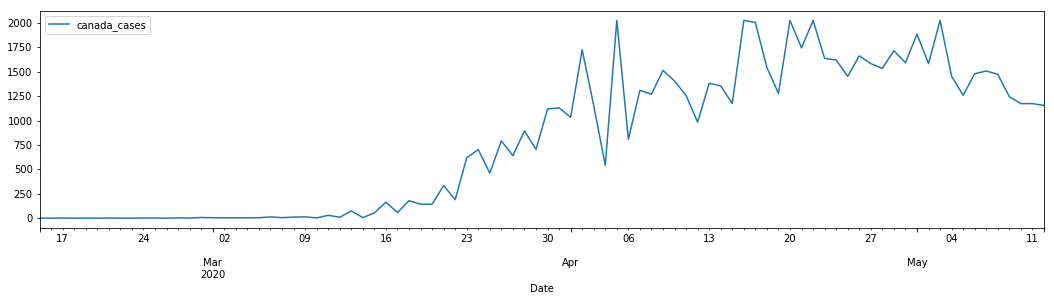

In [9]:
fig=canada_final.plot(figsize=(18,4))
display(fig.figure)

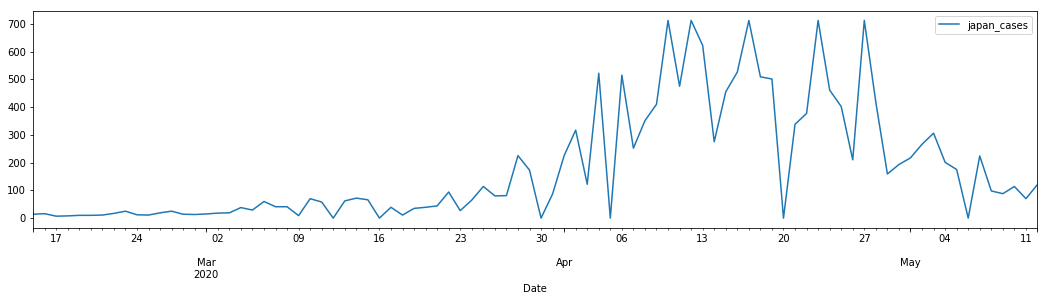

In [10]:
fig=japan_final.plot(figsize=(18,4))
display(fig.figure)

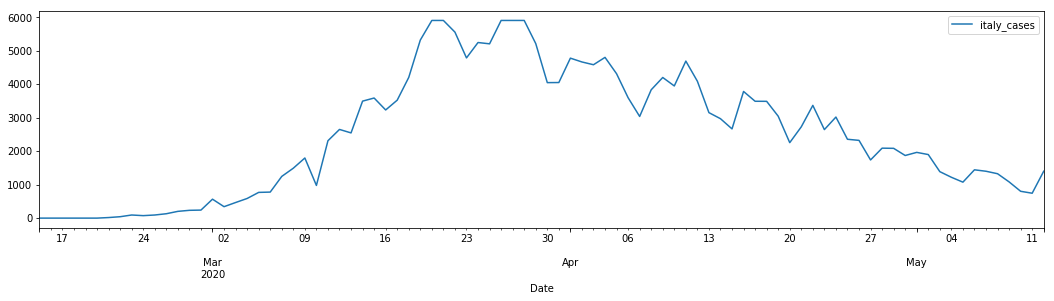

In [11]:
fig=italy_final.plot(figsize=(18,4))
display(fig.figure)

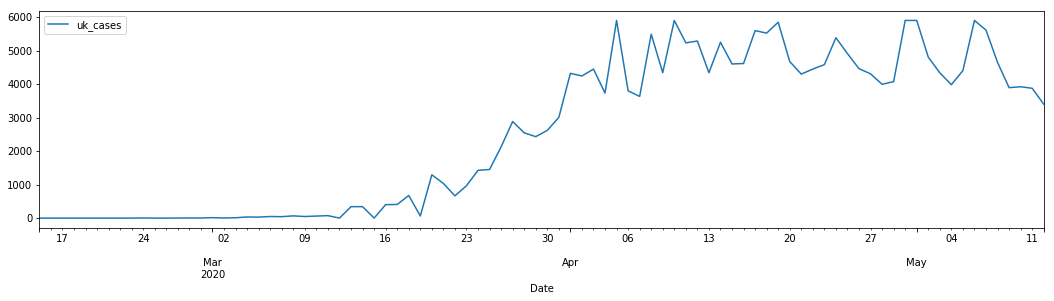

In [12]:
fig=uk_final.plot(figsize=(18,4))
display(fig.figure)

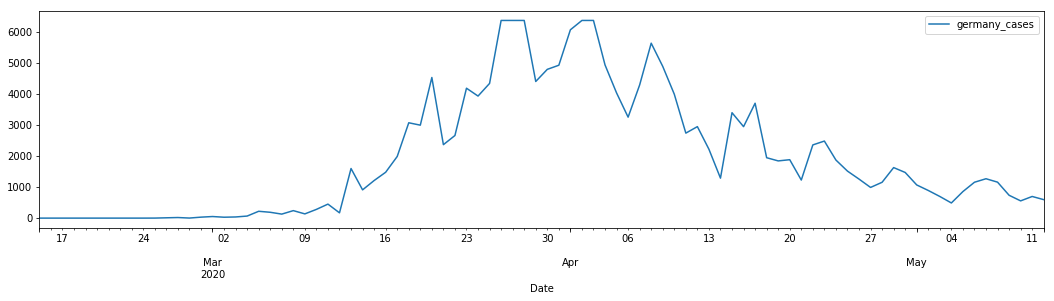

In [13]:
fig=germany_final.plot(figsize=(18,4))
display(fig.figure)

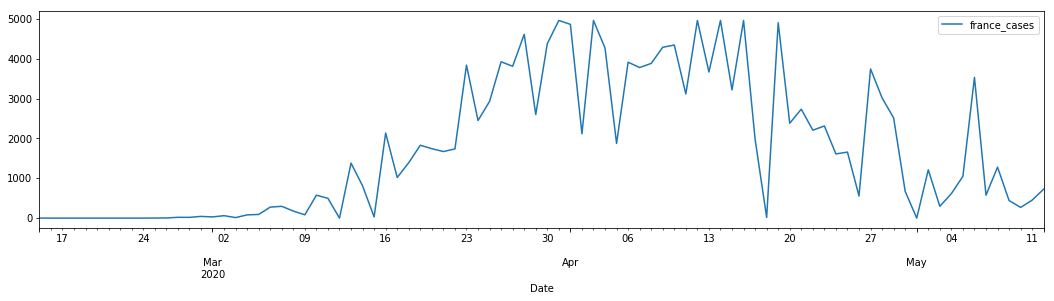

In [14]:
fig=france_final.plot(figsize=(18,4))
display(fig.figure)

# Rolling mean

In [16]:
# from pyspark.sql.window import Window

# w = Window.orderBy(col('Date').cast('long')).rangeBetween(-6, 0)

# rolmean_can = canada_cases.withColumn('rolling_average', avg("canada_cases").over(w))
# rolmean_can_pandas = rolmean_can.toPandas()
# rolmean_can_pandas['Date'] = pd.to_datetime(rolmean_can_pandas['Date'], infer_datetime_format = True)
# rolmean_can_final = rolmean_can_pandas.set_index('Date')

# rolmean_jap = japan_cases.withColumn('rolling_average', avg("japan_cases").over(w))
# rolmean_jap_pandas = rolmean_jap.toPandas()
# rolmean_jap_pandas['Date'] = pd.to_datetime(rolmean_jap_pandas['Date'], infer_datetime_format = True)
# rolmean_jap_final = rolmean_jap_pandas.set_index('Date')

# rolmean_ita = italy_cases.withColumn('rolling_average', avg("italy_cases").over(w))
# rolmean_ita_pandas = rolmean_ita.toPandas()
# rolmean_ita_pandas['Date'] = pd.to_datetime(rolmean_ita_pandas['Date'], infer_datetime_format = True)
# rolmean_ita_final = rolmean_ita_pandas.set_index('Date')

# rolmean_uk = uk_cases.withColumn('rolling_average', avg("uk_cases").over(w))
# rolmean_uk_pandas = rolmean_uk.toPandas()
# rolmean_uk_pandas['Date'] = pd.to_datetime(rolmean_uk_pandas['Date'], infer_datetime_format = True)
# rolmean_uk_final = rolmean_uk_pandas.set_index('Date')

# rolmean_ger = germany_cases.withColumn('rolling_average', avg("germany_cases").over(w))
# rolmean_ger_pandas = rolmean_ger.toPandas()
# rolmean_ger_pandas['Date'] = pd.to_datetime(rolmean_ger_pandas['Date'], infer_datetime_format = True)
# rolmean_ger_final = rolmean_ger_pandas.set_index('Date')

# rolmean_fra = france_cases.withColumn('rolling_average', avg("france_cases").over(w))
# rolmean_fra_pandas = rolmean_fra.toPandas()
# rolmean_fra_pandas['Date'] = pd.to_datetime(rolmean_fra_pandas['Date'], infer_datetime_format = True)
# rolmean_fra_final = rolmean_fra_pandas.set_index('Date')

In [17]:
# fig1 = rolmean_can_final.plot(figsize=(18,4)) 
# display(fig1.figure)

In [18]:
# fig1 = rolmean_jap_final.plot(figsize=(18,4)) 
# display(fig1_jap.figure)

In [19]:
# fig1 = rolmean_ita_final.plot(figsize=(18,4)) 
# display(fig1_ita.figure)

In [20]:
# fig1 = rolmean_uk_final.plot(figsize=(18,4)) 
# display(fig1_uk.figure)

In [21]:
# fig1 = rolmean_ger_final.plot(figsize=(18,4)) 
# display(fig1_ger.figure)

In [22]:
# fig1 = rolmean_fra_final.plot(figsize=(18,4)) 
# display(fig1_fra.figure)

# Stationarity test

In [24]:
def test_stationarity(timeseries):
         
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #print(dftest)
    print(dfoutput)
 
test_stationarity(canada_final)

test_stationarity(japan_final)

test_stationarity(italy_final)

test_stationarity(uk_final)

test_stationarity(germany_final)

test_stationarity(france_final)

Results of Dickey-Fuller Test:
Test Statistic -1.090306
p-value 0.718922
#Lags Used 2.000000
Number of Observations Used 85.000000
Critical Value (1%) -3.509736
Critical Value (5%) -2.896195
Critical Value (10%) -2.585258
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -1.477088
p-value 0.544814
#Lags Used 9.000000
Number of Observations Used 78.000000
Critical Value (1%) -3.517114
Critical Value (5%) -2.899375
Critical Value (10%) -2.586955
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -3.012126
p-value 0.033777
#Lags Used 8.000000
Number of Observations Used 79.000000
Critical Value (1%) -3.515977
Critical Value (5%) -2.898886
Critical Value (10%) -2.586694
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -2.051260
p-value 0.264559
#Lags Used 10.000000
Number of Observations Used 77.000000
Critical Value (1%) -3.518281
Critical Value (5%) -2.899878
Critical Value (10%) -2.587223
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -2.837722
p-value 0.053084
#Lags Used 10.000000
Number of Observations Used 77.000000
Critical Value (1%) -3.518281
Critical Value (5%) -2.899878
Critical Value (10%) -2.587223
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -1.438874
p-value 0.563504
#Lags Used 12.000000
Number of Observations Used 75.000000
Critical Value (1%) -3.520713
Critical Value (5%) -2.900925
Critical Value (10%) -2.587781
dtype: float64

# Logs (to increase stationarity)

In [26]:
#since we can't do logs of 0, change 0s to 1

#canada_final["canada_cases"] = canada_final["canada_cases"].replace(0, 1)

japan_final["japan_cases"] = japan_final["japan_cases"].replace(0, 1)

italy_final["italy_cases"] = italy_final["italy_cases"].replace(0, 1)

uk_final["uk_cases"] = uk_final["uk_cases"].replace(0, 1)

#germany_final["germany_cases"] = germany_final["germany_cases"].replace(0, 1)

france_final["france_cases"] = france_final["france_cases"].replace(0, 1)

/local_disk0/tmp/1597784351842-0/PythonShell.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import linecache
/local_disk0/tmp/1597784351842-0/PythonShell.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import pickle
/local_disk0/tmp/1597784351842-0/PythonShell.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import signal
/local_disk0/tmp/1597784351842-0/PythonShell.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import sys

In [27]:
#ts_log = np.log(canada_final)

#fig_log=ts_log.plot(figsize=(18, 6))
#display(fig_log.figure)

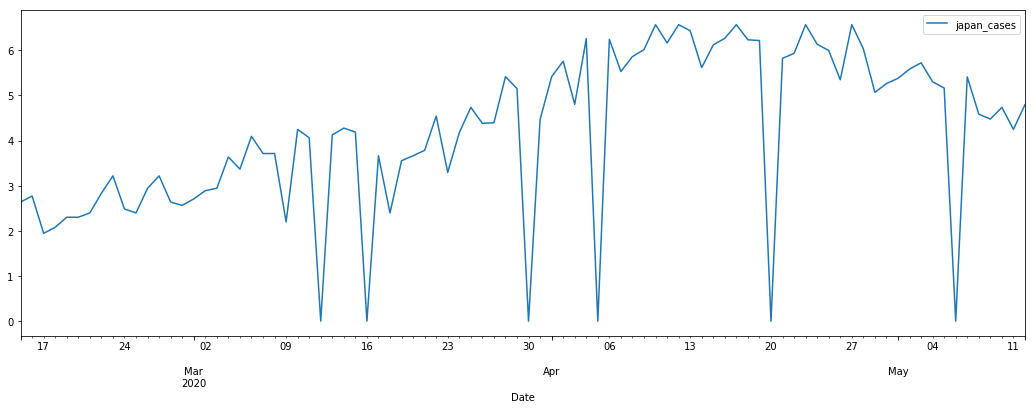

In [28]:
ts_jap_log = np.log(japan_final)

fig_log=ts_jap_log.plot(figsize=(18, 6))
display(fig_log.figure)

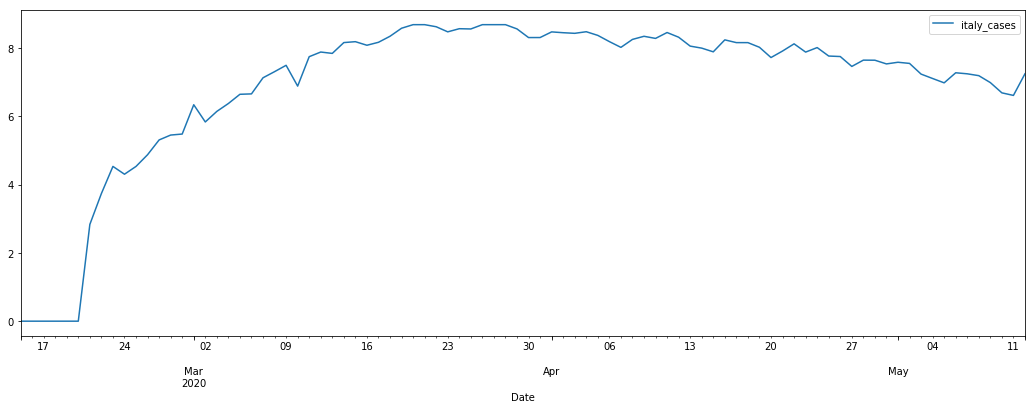

In [29]:
ts_ita_log = np.log(italy_final)

fig_log=ts_ita_log.plot(figsize=(18, 6))
display(fig_log.figure)

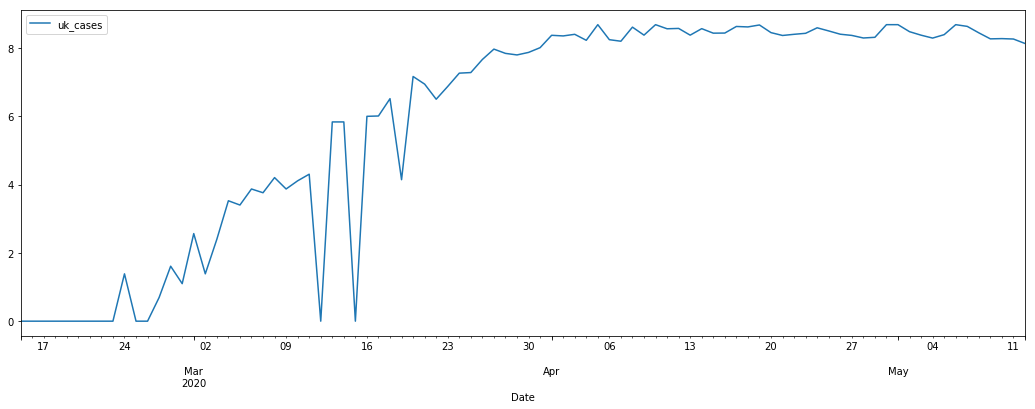

In [30]:
ts_uk_log = np.log(uk_final)

fig_log=ts_uk_log.plot(figsize=(18, 6))
display(fig_log.figure)

In [31]:
#ts_ger_log = np.log(germany_final)

#fig_log=ts_ger_log.plot(figsize=(18, 6))
#display(fig_log.figure)

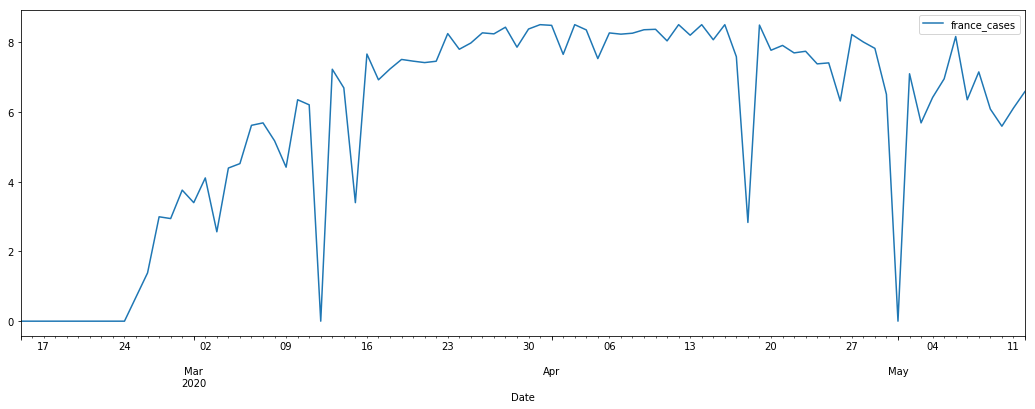

In [32]:
ts_fra_log = np.log(france_final)

fig_log=ts_fra_log.plot(figsize=(18, 6))
display(fig_log.figure)

In [33]:
#test_stationarity(ts_log)

test_stationarity(ts_jap_log)

test_stationarity(ts_ita_log)

test_stationarity(ts_uk_log)

#test_stationarity(ts_ger_log)

test_stationarity(ts_fra_log)

Results of Dickey-Fuller Test:
Test Statistic -1.767360
p-value 0.396783
#Lags Used 5.000000
Number of Observations Used 82.000000
Critical Value (1%) -3.512738
Critical Value (5%) -2.897490
Critical Value (10%) -2.585949
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -4.179159
p-value 0.000715
#Lags Used 1.000000
Number of Observations Used 86.000000
Critical Value (1%) -3.508783
Critical Value (5%) -2.895784
Critical Value (10%) -2.585038
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -2.375120
p-value 0.148882
#Lags Used 5.000000
Number of Observations Used 82.000000
Critical Value (1%) -3.512738
Critical Value (5%) -2.897490
Critical Value (10%) -2.585949
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -2.266286
p-value 0.183072
#Lags Used 2.000000
Number of Observations Used 85.000000
Critical Value (1%) -3.509736
Critical Value (5%) -2.896195
Critical Value (10%) -2.585258
dtype: float64

# Differencing (to increase stationarity)

In [35]:
#ts_log['canada_cases'] = ts_log['canada_cases'].diff()
ts_jap_log['japan_cases'] = ts_jap_log['japan_cases'].diff()
ts_ita_log['italy_cases'] = ts_ita_log['italy_cases'].diff()
ts_uk_log['uk_cases'] = ts_uk_log['uk_cases'].diff()
#ts_ger_log['germany_cases'] = ts_ger_log['germany_cases'].diff()
ts_fra_log['france_cases'] = ts_fra_log['france_cases'].diff()

#ts_log['canada_cases'] = ts_log['canada_cases'].fillna(0)
ts_jap_log['japan_cases'] = ts_jap_log['japan_cases'].fillna(0)
ts_ita_log['italy_cases'] = ts_ita_log['italy_cases'].fillna(0)
ts_uk_log['uk_cases'] = ts_uk_log['uk_cases'].diff().fillna(0)
#ts_ger_log['germany_cases'] = ts_ger_log['germany_cases'].fillna(0)
ts_fra_log['france_cases'] = ts_fra_log['france_cases'].fillna(0)

In [36]:
#fig_log=ts_log.plot(figsize=(18, 6))
#display(fig_log.figure)

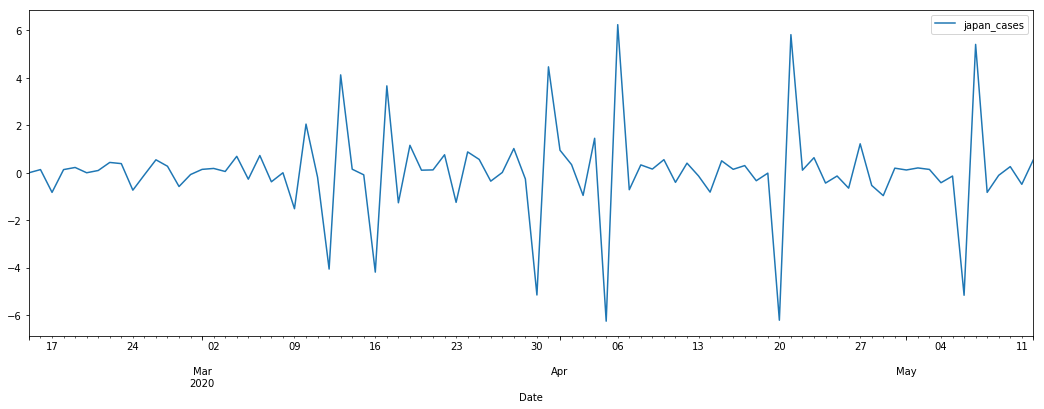

In [37]:
fig_log=ts_jap_log.plot(figsize=(18, 6))
display(fig_log.figure)

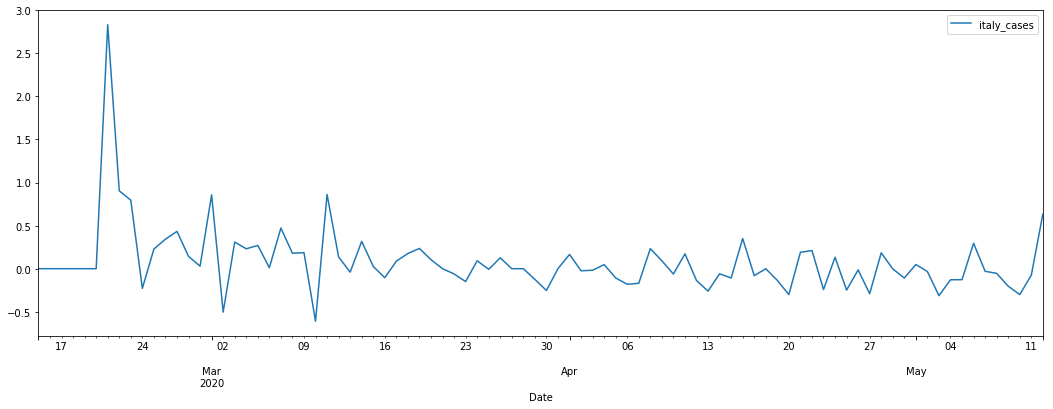

In [38]:
fig_log=ts_ita_log.plot(figsize=(18, 6))
display(fig_log.figure)

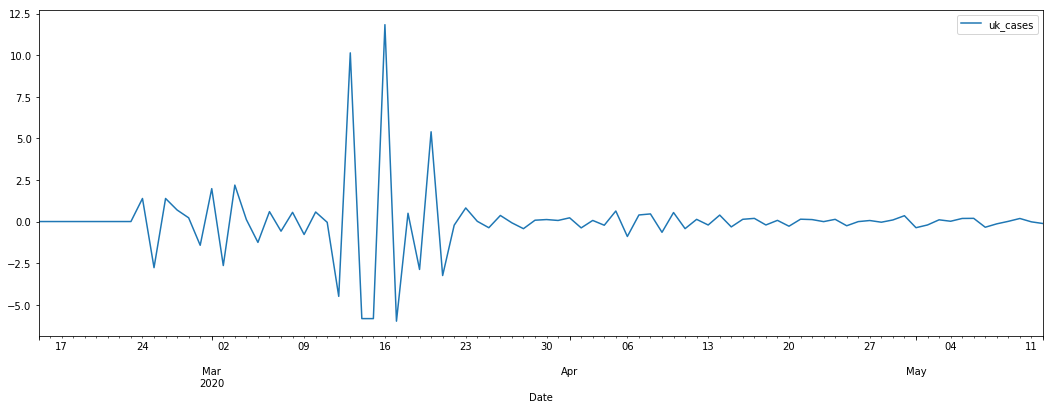

In [39]:
fig_log=ts_uk_log.plot(figsize=(18, 6))
display(fig_log.figure)

In [40]:
#fig_log=ts_ger_log.plot(figsize=(18, 6))
#display(fig_log.figure)

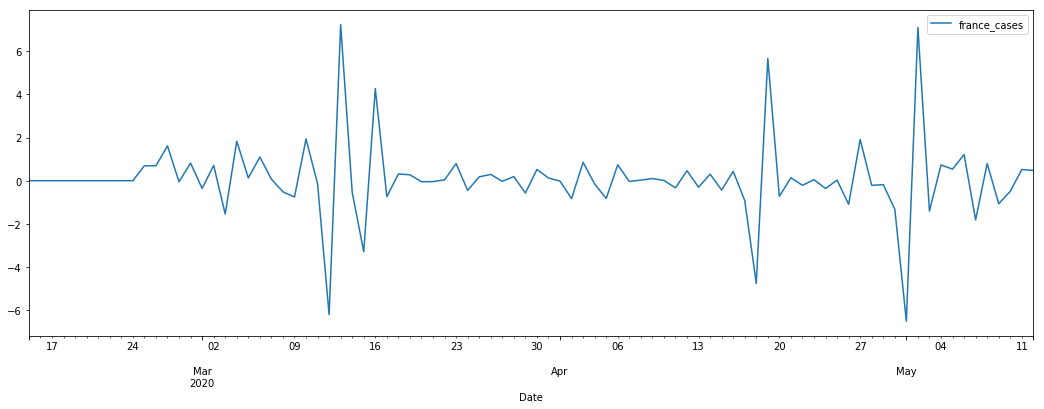

In [41]:
fig_log=ts_fra_log.plot(figsize=(18, 6))
display(fig_log.figure)

In [42]:
#test_stationarity(ts_log)

test_stationarity(ts_jap_log)

test_stationarity(ts_ita_log)

test_stationarity(ts_uk_log)

#test_stationarity(ts_ger_log)

test_stationarity(ts_fra_log)

Results of Dickey-Fuller Test:
Test Statistic -7.930037e+00
p-value 3.533236e-12
#Lags Used 4.000000e+00
Number of Observations Used 8.300000e+01
Critical Value (1%) -3.511712e+00
Critical Value (5%) -2.897048e+00
Critical Value (10%) -2.585713e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -4.673045
p-value 0.000095
#Lags Used 12.000000
Number of Observations Used 75.000000
Critical Value (1%) -3.520713
Critical Value (5%) -2.900925
Critical Value (10%) -2.587781
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -8.177975e+00
p-value 8.277660e-13
#Lags Used 5.000000e+00
Number of Observations Used 8.200000e+01
Critical Value (1%) -3.512738e+00
Critical Value (5%) -2.897490e+00
Critical Value (10%) -2.585949e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -1.228998e+01
p-value 7.867398e-23
#Lags Used 1.000000e+00
Number of Observations Used 8.600000e+01
Critical Value (1%) -3.508783e+00
Critical Value (5%) -2.895784e+00
Critical Value (10%) -2.585038e+00
dtype: float64

# Differencing without log

In [44]:
can_diff = canada_final
#jap_diff = japan_final
#ita_diff = italy_final
#uk_diff = uk_final
#ger_diff = germany_final
#fra_diff = france_final

can_diff['canada_cases'] = can_diff['canada_cases'].diff()
#jap_diff['japan_cases'] = jap_diff['japan_cases'].diff()
#ita_diff['italy_cases'] = ita_diff['italy_cases'].diff()
#uk_diff['uk_cases'] = uk_diff['uk_cases'].diff()
#ger_diff['germany_cases'] = ger_diff['germany_cases'].diff()
#fra_diff['france_cases'] = fra_diff['france_cases'].diff()

can_diff['canada_cases'] = can_diff['canada_cases'].fillna(0)
#jap_diff['japan_cases'] = jap_diff['japan_cases'].fillna(0)
#ita_diff['italy_cases'] = ita_diff['italy_cases'].fillna(0)
#uk_diff['uk_cases'] = uk_diff['uk_cases'].diff().fillna(0)
#ger_diff['germany_cases'] = ger_diff['germany_cases'].fillna(0)
#fra_diff['france_cases'] = fra_diff['france_cases'].fillna(0)

/local_disk0/tmp/1597784351842-0/PythonShell.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import resource
/local_disk0/tmp/1597784351842-0/PythonShell.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import traceback

In [45]:
test_stationarity(can_diff)

#test_stationarity(jap_diff)

#test_stationarity(ita_diff)

#test_stationarity(uk_diff)

#test_stationarity(ger_diff)

#test_stationarity(fra_diff)

Results of Dickey-Fuller Test:
Test Statistic -1.222546e+01
p-value 1.083107e-22
#Lags Used 1.000000e+00
Number of Observations Used 8.600000e+01
Critical Value (1%) -3.508783e+00
Critical Value (5%) -2.895784e+00
Critical Value (10%) -2.585038e+00
dtype: float64

In [46]:
# CHOOSING THE MOST STATIONARY DATA FOR EACH COUNTRY

#country -> original(canada_final), log, log+diff (ts_jap_log), diff (can_diff)

#can -> 0.623984, 0.014365 , 0.545969, [[[1.083107e-22]]]

#jap -> 0.511131, 0.285709, [[[1.256811e-14]]] , 0.019711

#ita -> 0.064367, 0.934665 , [[[0.000011]]] , 0.277255

#uk -> 0.478642, 0.038005, [[[3.460263e-16]]] , 5.414207e-10

#ger -> [[[0.048243]]], 0.302117, 0.720871 , 0.242906

#fra -> 0.507965, 0.076173, [[[3.985235e-25]]] , 0.041409

In [47]:
can_test_diff = canada_test

can_test_diff['canada_cases'] = can_test_diff['canada_cases'].diff()

can_test_diff['canada_cases'] = can_test_diff['canada_cases'].fillna(0)


/local_disk0/tmp/1597784351842-0/PythonShell.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 
/local_disk0/tmp/1597784351842-0/PythonShell.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import linecache

In [48]:
test_stationarity(can_test_diff)

Results of Dickey-Fuller Test:
Test Statistic -1.323234
p-value 0.618477
#Lags Used 6.000000
Number of Observations Used 22.000000
Critical Value (1%) -3.769733
Critical Value (5%) -3.005426
Critical Value (10%) -2.642501
dtype: float64

In [49]:
japan_test["japan_cases"] = japan_test["japan_cases"].replace(0, 1)

italy_test["italy_cases"] = italy_test["italy_cases"].replace(0, 1)

uk_test["uk_cases"] = uk_test["uk_cases"].replace(0, 1)

france_test["france_cases"] = france_test["france_cases"].replace(0, 1)

test_jap_log = np.log(japan_test)

test_ita_log = np.log(italy_test)

test_uk_log = np.log(uk_test)

test_fra_log = np.log(france_test)

test_jap_log['japan_cases'] = test_jap_log['japan_cases'].diff()
test_jap_log['japan_cases'] = test_jap_log['japan_cases'].fillna(0)

test_ita_log['italy_cases'] = test_ita_log['italy_cases'].diff()
test_ita_log['italy_cases'] = test_ita_log['italy_cases'].fillna(0)

test_uk_log['uk_cases'] = test_uk_log['uk_cases'].diff()
test_uk_log['uk_cases'] = test_uk_log['uk_cases'].fillna(0)

test_fra_log['france_cases'] = test_fra_log['france_cases'].diff()
test_fra_log['france_cases'] = test_fra_log['france_cases'].fillna(0)

/local_disk0/tmp/1597784351842-0/PythonShell.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 from __future__ import absolute_import
/local_disk0/tmp/1597784351842-0/PythonShell.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 
/local_disk0/tmp/1597784351842-0/PythonShell.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import linecache
/local_disk0/tmp/1597784351842-0/PythonShell.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import pickle

In [50]:
test_stationarity(test_jap_log)
test_stationarity(test_ita_log)
test_stationarity(test_uk_log)
test_stationarity(test_fra_log)

test_stationarity(germany_test)

Results of Dickey-Fuller Test:
Test Statistic -5.868043e+00
p-value 3.289912e-07
#Lags Used 2.000000e+00
Number of Observations Used 2.600000e+01
Critical Value (1%) -3.711212e+00
Critical Value (5%) -2.981247e+00
Critical Value (10%) -2.630095e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -5.196341
p-value 0.000009
#Lags Used 5.000000
Number of Observations Used 23.000000
Critical Value (1%) -3.752928
Critical Value (5%) -2.998500
Critical Value (10%) -2.638967
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -3.038041
p-value 0.031491
#Lags Used 9.000000
Number of Observations Used 19.000000
Critical Value (1%) -3.832603
Critical Value (5%) -3.031227
Critical Value (10%) -2.655520
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -6.056355e+00
p-value 1.242466e-07
#Lags Used 0.000000e+00
Number of Observations Used 2.800000e+01
Critical Value (1%) -3.688926e+00
Critical Value (5%) -2.971989e+00
Critical Value (10%) -2.625296e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic -2.377536
p-value 0.148177
#Lags Used 8.000000
Number of Observations Used 20.000000
Critical Value (1%) -3.809209
Critical Value (5%) -3.021645
Critical Value (10%) -2.650713
dtype: float64

# Final Graphs

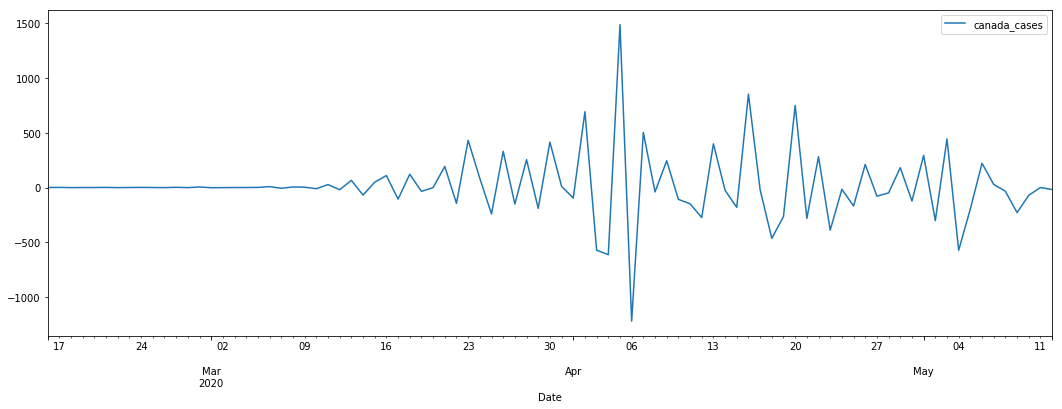

In [52]:
can_diff.drop(can_diff.index[0], inplace=True)

fig=can_diff.plot(figsize=(18, 6))
display(fig.figure)

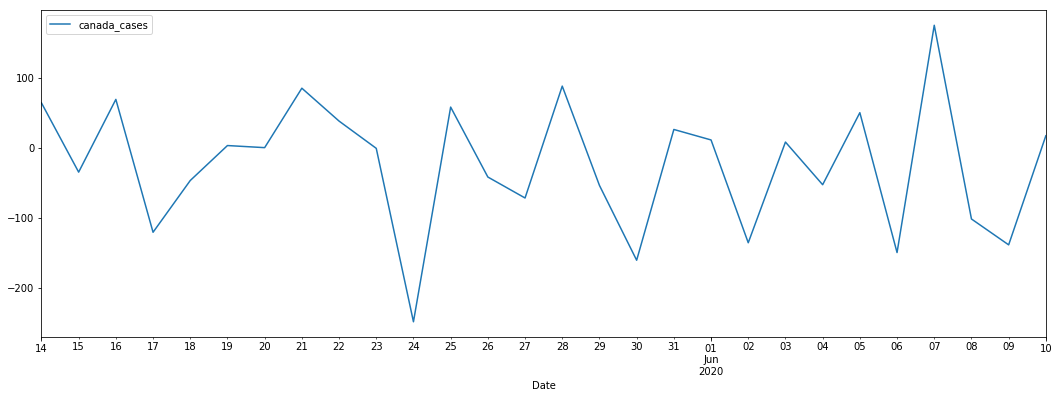

In [53]:
can_test_diff.drop(can_test_diff.index[0], inplace=True)

fig=can_test_diff.plot(figsize=(18, 6))
display(fig.figure)

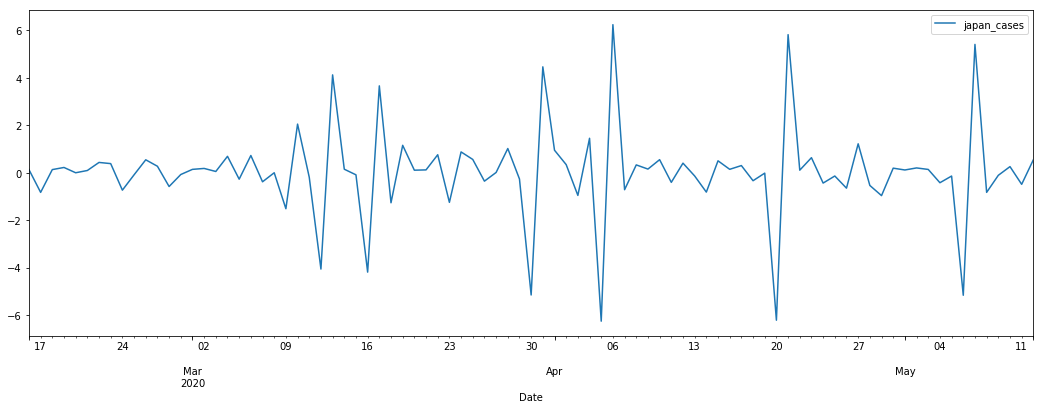

In [54]:
ts_jap_log.drop(ts_jap_log.index[0], inplace=True)

fig=ts_jap_log.plot(figsize=(18, 6))
display(fig.figure)

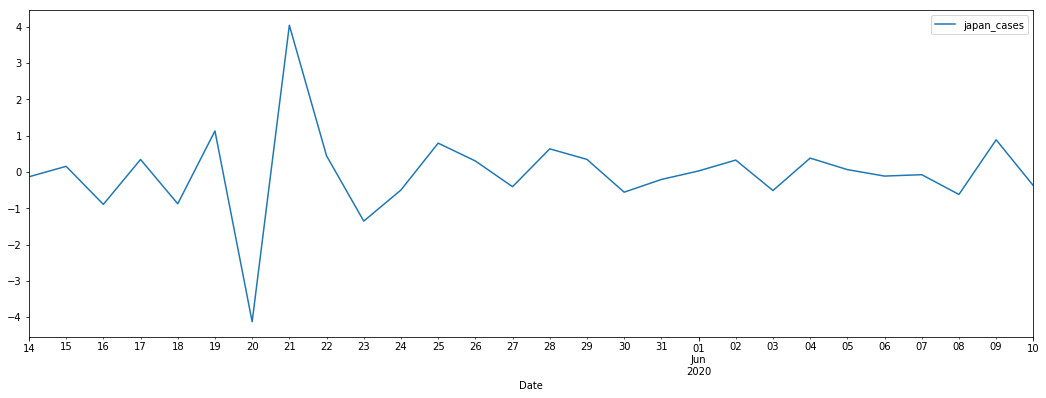

In [55]:
test_jap_log.drop(test_jap_log.index[0], inplace=True)

fig=test_jap_log.plot(figsize=(18, 6))
display(fig.figure)

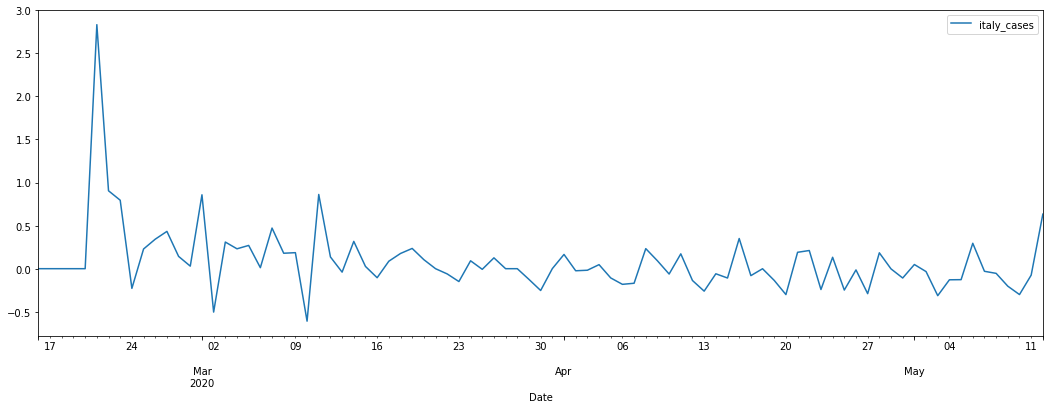

In [56]:
ts_ita_log.drop(ts_ita_log.index[0], inplace=True)

fig=ts_ita_log.plot(figsize=(18, 6))
display(fig.figure)

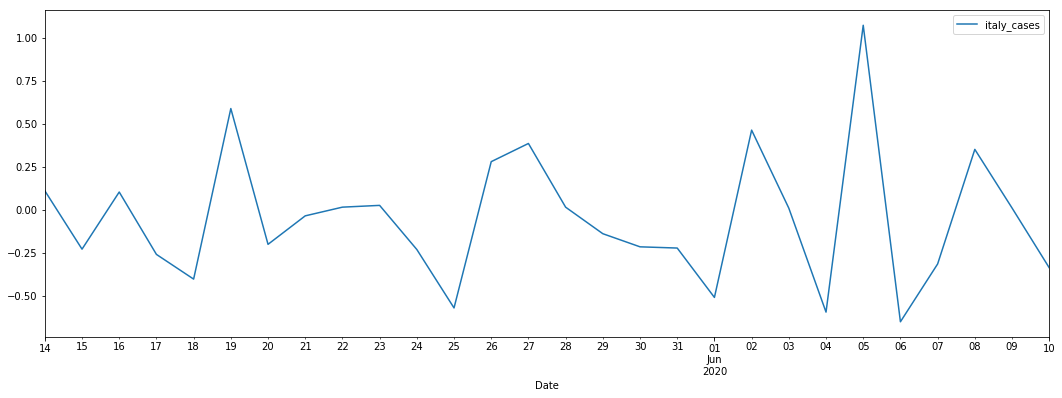

In [57]:
test_ita_log.drop(test_ita_log.index[0], inplace=True)

fig=test_ita_log.plot(figsize=(18, 6))
display(fig.figure)

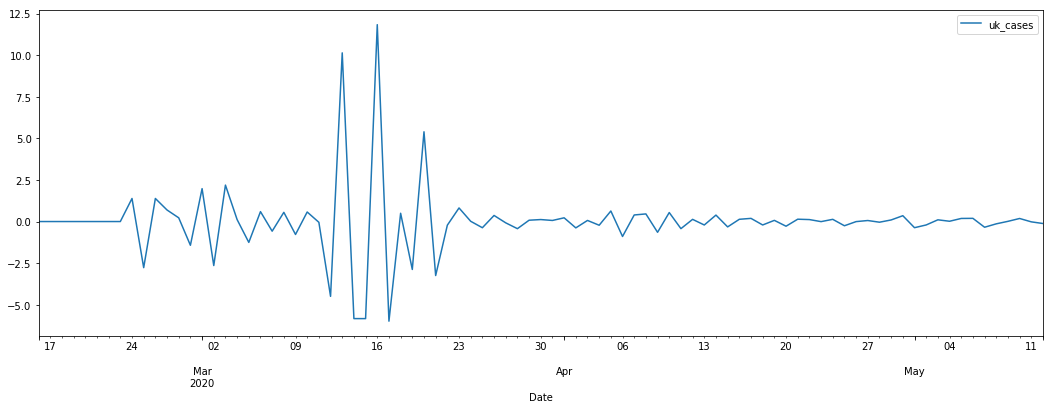

In [58]:
ts_uk_log.drop(ts_uk_log.index[0], inplace=True)

fig=ts_uk_log.plot(figsize=(18, 6))
display(fig.figure)

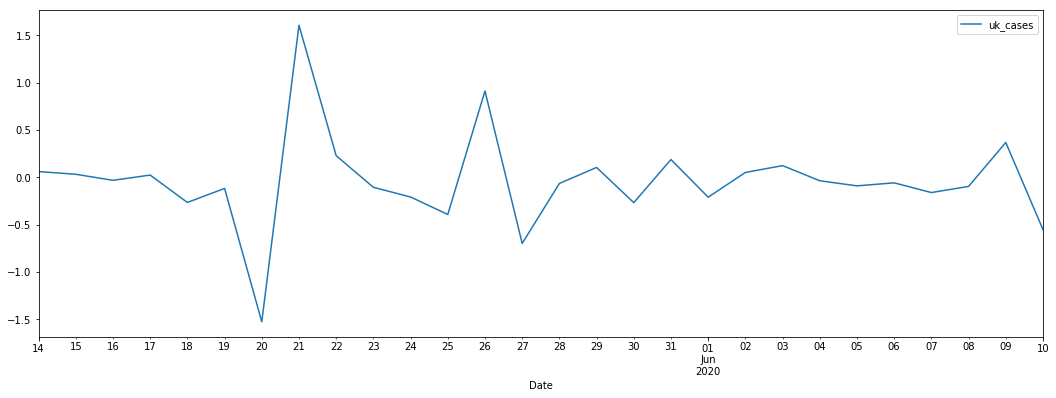

In [59]:
test_uk_log.drop(test_uk_log.index[0], inplace=True)

fig=test_uk_log.plot(figsize=(18, 6))
display(fig.figure)

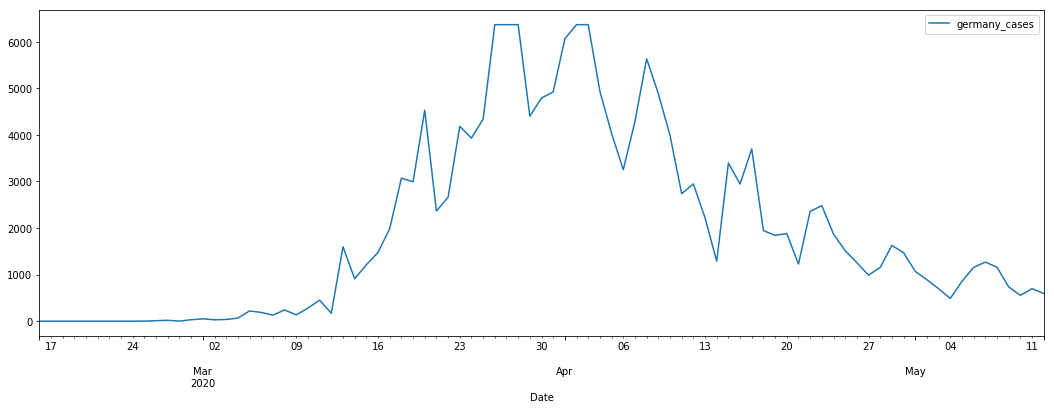

In [60]:
germany_final.drop(germany_final.index[0], inplace=True)

fig=germany_final.plot(figsize=(18, 6))
display(fig.figure)

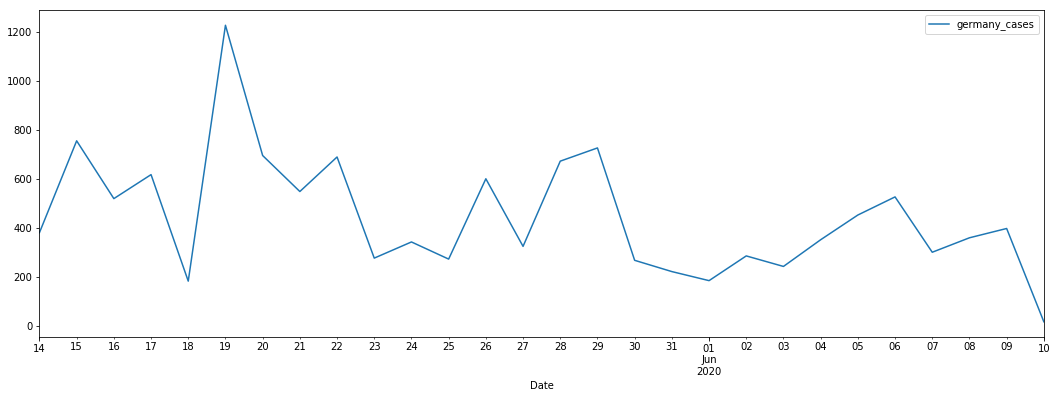

In [61]:
germany_test.drop(germany_test.index[0], inplace=True)

fig=germany_test.plot(figsize=(18, 6))
display(fig.figure)

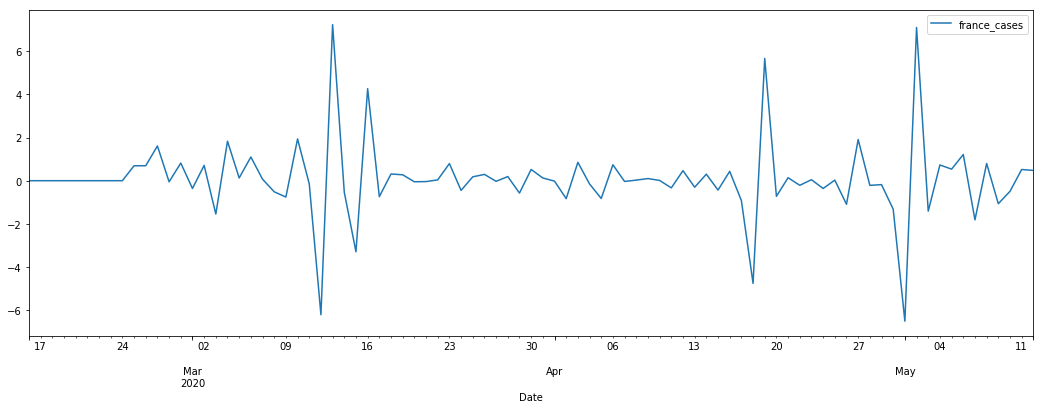

In [62]:
ts_fra_log.drop(ts_fra_log.index[0], inplace=True)

fig=ts_fra_log.plot(figsize=(18, 6))
display(fig.figure)

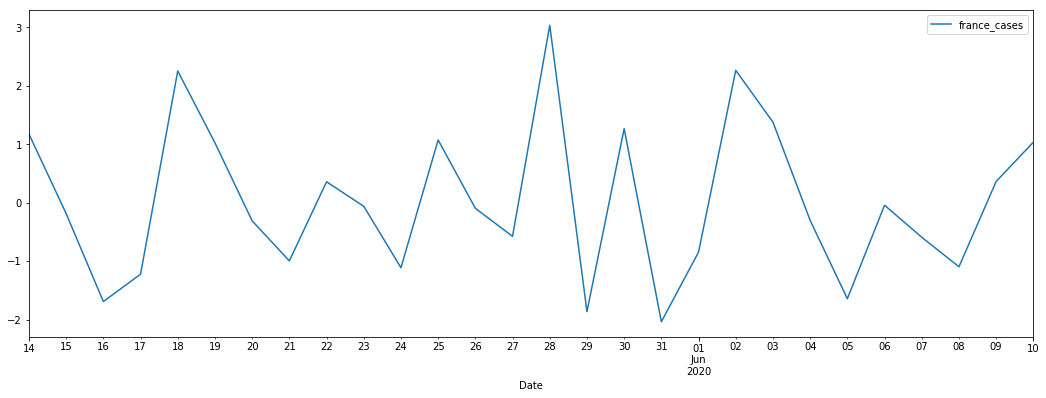

In [63]:
test_fra_log.drop(test_fra_log.index[0], inplace=True)

fig=test_fra_log.plot(figsize=(18, 6))
display(fig.figure)

# ACF, PACF

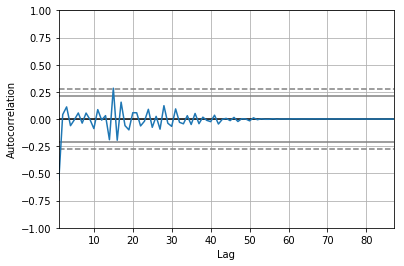

In [65]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(can_diff)
pyplot.show()

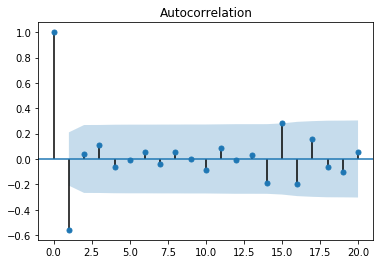

In [66]:
lag_acf = plot_acf(can_diff, lags=20)
display(lag_acf)

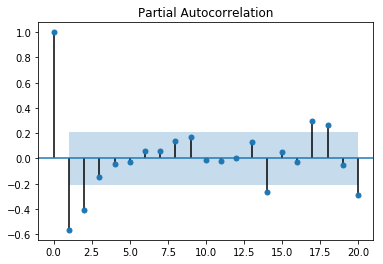

In [67]:
lag_pacf = plot_pacf(can_diff, lags=20)
display(lag_pacf)

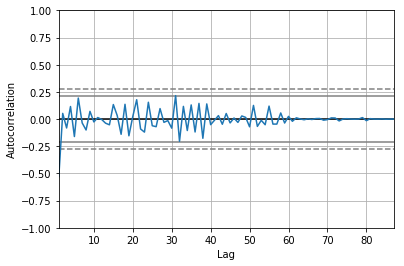

In [68]:
autocorrelation_plot(ts_jap_log)
pyplot.show()

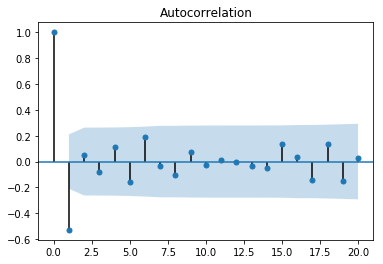

In [69]:
lag_jap_acf = plot_acf(ts_jap_log, lags=20)
display(lag_jap_acf)

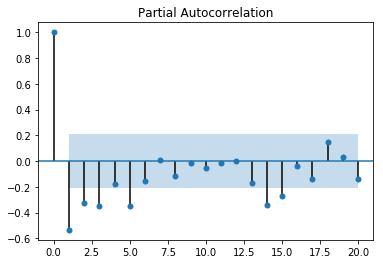

In [70]:
lag_pacf = plot_pacf(ts_jap_log, lags=20)
display(lag_pacf)

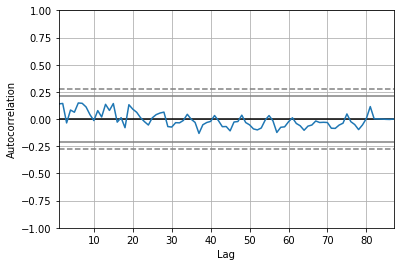

In [71]:
autocorrelation_plot(ts_ita_log)
pyplot.show()

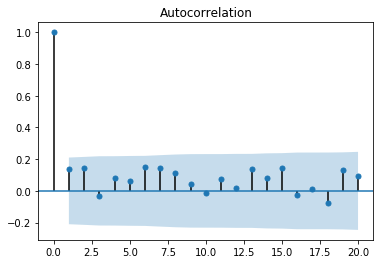

In [72]:
lag_ita_acf = plot_acf(ts_ita_log, lags=20)
display(lag_ita_acf)

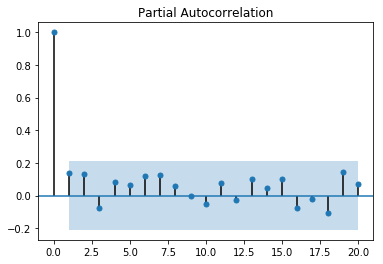

In [73]:
lag_pacf = plot_pacf(ts_ita_log, lags=20)
display(lag_pacf)

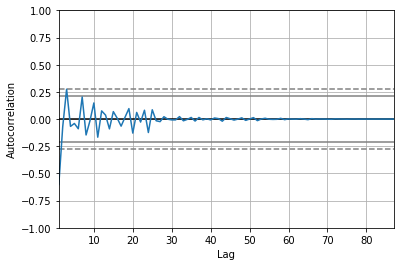

In [74]:
autocorrelation_plot(ts_uk_log)
pyplot.show()

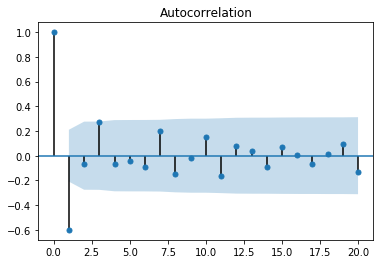

In [75]:
lag_uk_acf = plot_acf(ts_uk_log, lags=20)
display(lag_uk_acf)

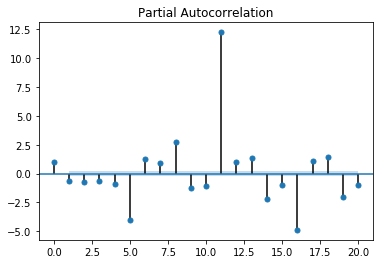

In [76]:
lag_pacf = plot_pacf(ts_uk_log, lags=20)
display(lag_pacf)

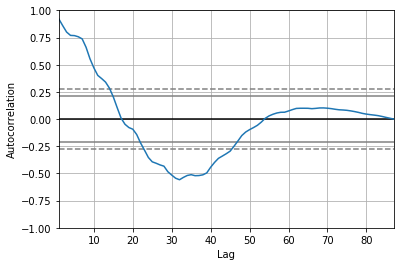

In [77]:
autocorrelation_plot(germany_final)
pyplot.show()

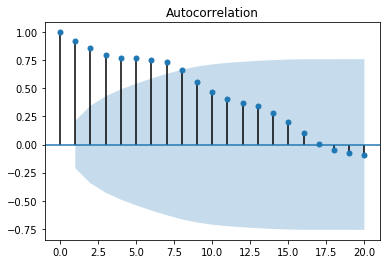

In [78]:
lag_ger_acf = plot_acf(germany_final, lags=20)
display(lag_ger_acf)

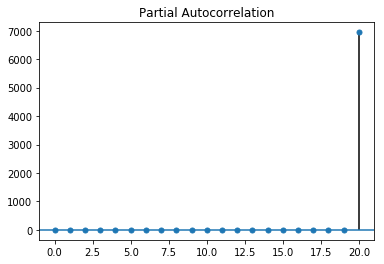

In [79]:
lag_pacf = plot_pacf(germany_final, lags=20)
display(lag_pacf)

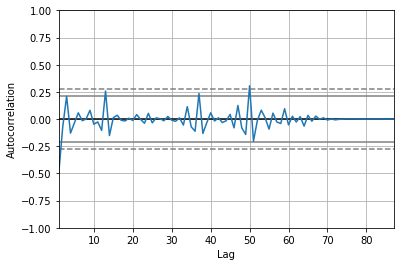

In [80]:
autocorrelation_plot(ts_fra_log)
pyplot.show()

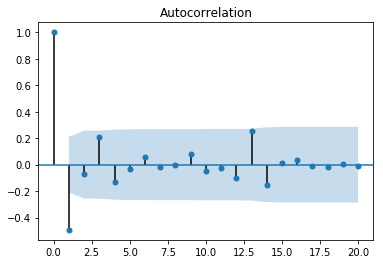

In [81]:
lag_fra_acf = plot_acf(ts_fra_log, lags=20)
display(lag_fra_acf)

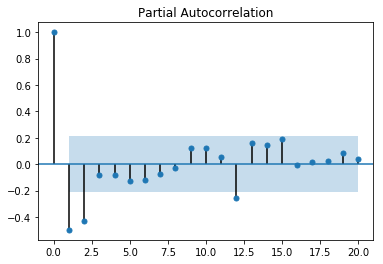

In [82]:
lag_pacf = plot_pacf(ts_fra_log, lags=20)
display(lag_pacf)

# ARIMA SUMMARY

In [84]:
import math

model = ARIMA(can_diff.astype(float), order=(0, 1, 1)) 
results_ARIMA = model.fit(maxiter=500)  
print(results_ARIMA.summary())

/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated. Use `pandas.date_range` instead.
 start=index[0], end=index[-1], freq=freq)
/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
 ARIMA Model Results 
==============================================================================
Dep. Variable: D.canada_cases No. Observations: 86
Model: ARIMA(0, 1, 1) Log Likelihood -621.658
Method: css-mle S.D. of innovations 324.953
Date: Tue, 18 Aug 2020 AIC 1249.316
Time: 21:07:23 BIC 1256.679
Sample: 02-17-2020 HQIC 1252.280
 - 05-12-2020 
========================================================================================
 coef std err z P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
const -0.3547 1.387 -0.256 0.799 -3.074 2.364
ma.L1.D.canada_cases -1.0000 0.030 -33.036 0.000 -1.059 -0.941
 Roots 
=============================================================================
 Real Imaginary Modulus Frequency
-----------------------------------------------------------------------------
MA.1 1.0000 +0.0000j 1.0000 0.0000
-----------------------------------------------------------------------------

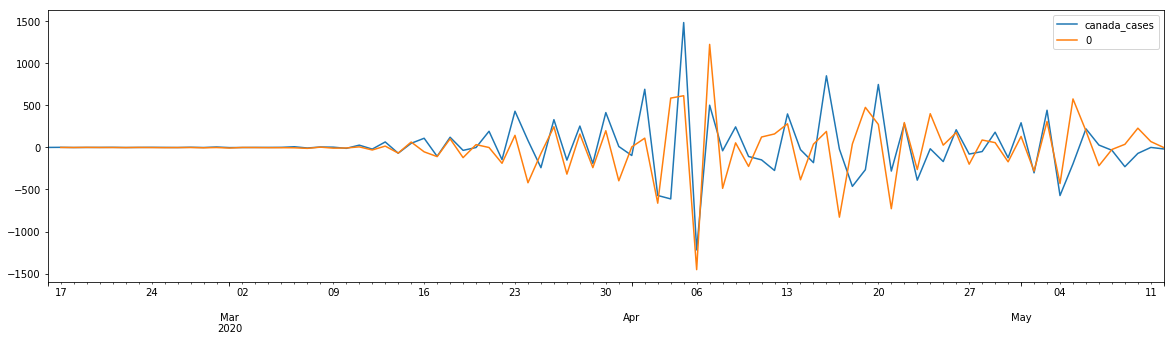

In [85]:
fitted_values  = results_ARIMA.predict(1,len(can_diff)-1,typ='linear')
fitted_values_frame = fitted_values.to_frame()

x = can_diff.merge(fitted_values_frame, how='outer', left_index=True, right_index=True)

fig= x.plot(y = ["canada_cases", 0], figsize=(20,5))
display(fig.figure)

In [86]:
model_jap = ARIMA(ts_jap_log.astype(float), order=(1, 1, 0)) 
results_jap_ARIMA = model_jap.fit(maxiter=500) 
print(results_jap_ARIMA.summary())

/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
 ARIMA Model Results 
==============================================================================
Dep. Variable: D.japan_cases No. Observations: 86
Model: ARIMA(1, 1, 0) Log Likelihood -202.557
Method: css-mle S.D. of innovations 2.541
Date: Tue, 18 Aug 2020 AIC 411.115
Time: 21:07:24 BIC 418.478
Sample: 02-17-2020 HQIC 414.078
 - 05-12-2020 
=======================================================================================
 coef std err z P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
const 0.0045 0.164 0.028 0.978 -0.316 0.325
ar.L1.D.japan_cases -0.6831 0.077 -8.882 0.000 -0.834 -0.532
 Roots 
=============================================================================
 Real Imaginary Modulus Frequency
-----------------------------------------------------------------------------
AR.1 -1.4639 +0.0000j 1.4639 0.5000
-----------------------------------------------------------------------------

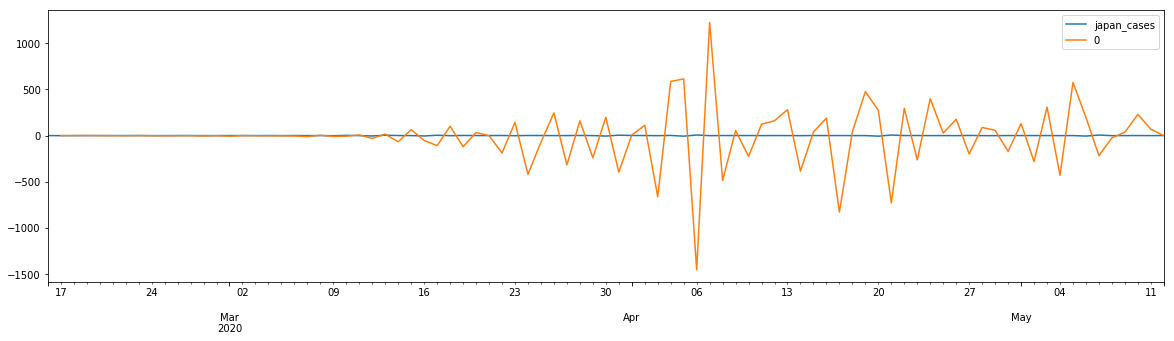

In [87]:
fitted_values  = results_ARIMA.predict(1,len(ts_jap_log)-1,typ='linear')
fitted_values_frame = fitted_values.to_frame()

x = ts_jap_log.merge(fitted_values_frame, how='outer', left_index=True, right_index=True)

fig= x.plot(y = ["japan_cases", 0], figsize=(20,5))
display(fig.figure)

In [88]:
model_ita = ARIMA(ts_ita_log.astype(float), order=(0, 1, 1)) 
results_ita_ARIMA = model_ita.fit(maxiter=500) 
print(results_ita_ARIMA.summary())

/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
 ARIMA Model Results 
==============================================================================
Dep. Variable: D.italy_cases No. Observations: 86
Model: ARIMA(0, 1, 1) Log Likelihood -40.912
Method: css-mle S.D. of innovations 0.379
Date: Tue, 18 Aug 2020 AIC 87.825
Time: 21:07:26 BIC 95.188
Sample: 02-17-2020 HQIC 90.788
 - 05-12-2020 
=======================================================================================
 coef std err z P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
const -0.0053 0.002 -3.292 0.001 -0.009 -0.002
ma.L1.D.italy_cases -0.9999 0.048 -20.868 0.000 -1.094 -0.906
 Roots 
=============================================================================
 Real Imaginary Modulus Frequency
-----------------------------------------------------------------------------
MA.1 1.0001 +0.0000j 1.0001 0.0000
-----------------------------------------------------------------------------

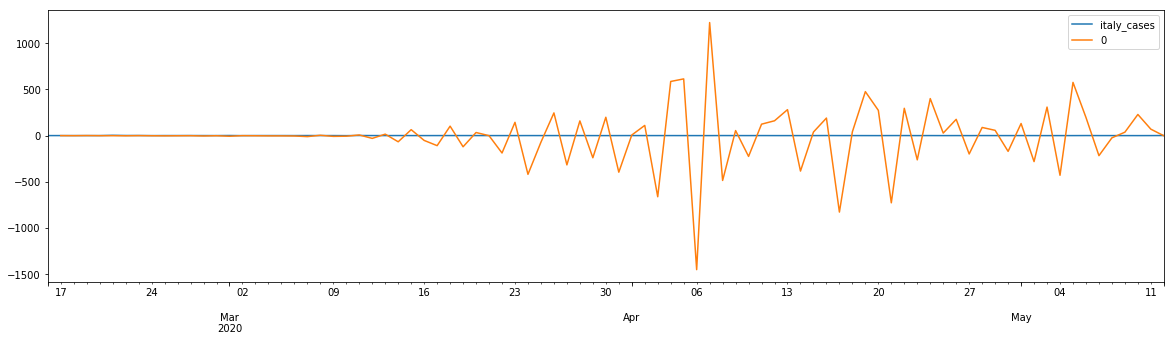

In [89]:
fitted_values  = results_ARIMA.predict(1,len(ts_ita_log)-1,typ='linear')
fitted_values_frame = fitted_values.to_frame()

x = ts_ita_log.merge(fitted_values_frame, how='outer', left_index=True, right_index=True)

fig= x.plot(y = ["italy_cases", 0], figsize=(20,5))
display(fig.figure)

In [90]:
model_uk = ARIMA(ts_uk_log.astype(float), order=(0, 1, 1)) 
results_uk_ARIMA = model_uk.fit(maxiter=500) 
print(results_uk_ARIMA.summary())

/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
 ARIMA Model Results 
==============================================================================
Dep. Variable: D.uk_cases No. Observations: 86
Model: ARIMA(0, 1, 1) Log Likelihood -195.768
Method: css-mle S.D. of innovations 2.297
Date: Tue, 18 Aug 2020 AIC 397.536
Time: 21:07:27 BIC 404.899
Sample: 02-17-2020 HQIC 400.499
 - 05-12-2020 
====================================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
const -0.0003 0.010 -0.026 0.979 -0.019 0.019
ma.L1.D.uk_cases -1.0000 0.028 -35.111 0.000 -1.056 -0.944
 Roots 
=============================================================================
 Real Imaginary Modulus Frequency
-----------------------------------------------------------------------------
MA.1 1.0000 +0.0000j 1.0000 0.0000
-----------------------------------------------------------------------------

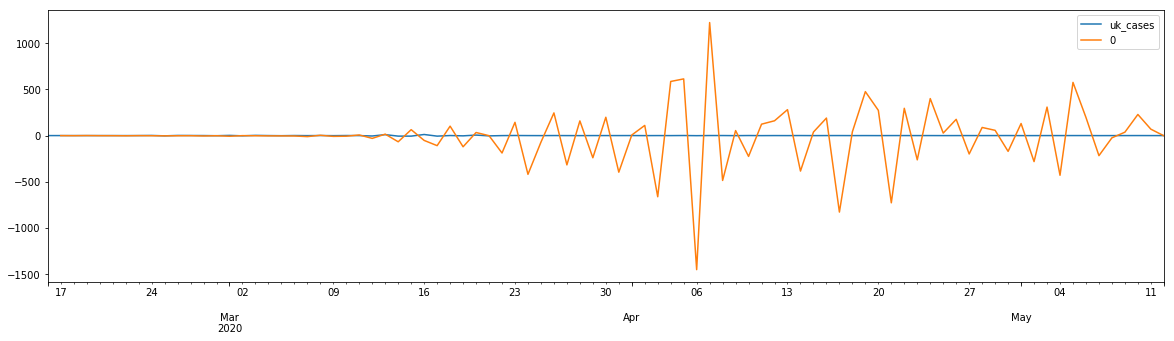

In [91]:
fitted_values  = results_ARIMA.predict(1,len(ts_uk_log)-1,typ='linear')
fitted_values_frame = fitted_values.to_frame()

x = ts_uk_log.merge(fitted_values_frame, how='outer', left_index=True, right_index=True)

fig= x.plot(y = ["uk_cases", 0], figsize=(20,5))
display(fig.figure)

In [92]:
model_ger = ARIMA(germany_final.astype(float), order=(1, 1, 1)) 
results_ger_ARIMA = model_ger.fit(maxiter=500) 
print(results_ger_ARIMA.summary())

/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
 ARIMA Model Results 
==============================================================================
Dep. Variable: D.germany_cases No. Observations: 86
Model: ARIMA(1, 1, 1) Log Likelihood -687.446
Method: css-mle S.D. of innovations 716.403
Date: Tue, 18 Aug 2020 AIC 1382.892
Time: 21:07:29 BIC 1392.709
Sample: 02-17-2020 HQIC 1386.843
 - 05-12-2020 
=========================================================================================
 coef std err z P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
const 7.7501 52.458 0.148 0.883 -95.066 110.566
ar.L1.D.germany_cases 0.4646 0.207 2.241 0.028 0.058 0.871
ma.L1.D.germany_cases -0.6403 0.165 -3.879 0.000 -0.964 -0.317
 Roots 
=============================================================================
 Real Imaginary Modulus Frequency
-----------------------------------------------------------------------------
AR.1 2.1524 +0.0000j 2.1524 0.0000
MA.1 1.5617 +0.0000j 1.5617 0.0000
-----------------------------------------------------------------------------

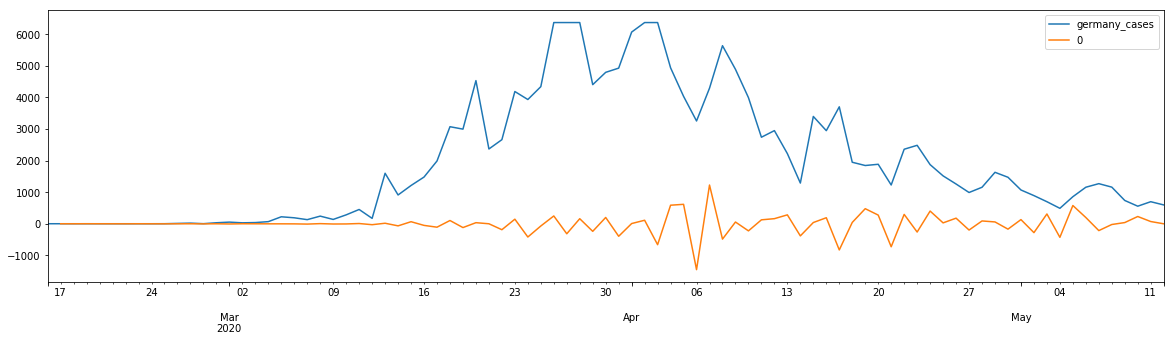

In [93]:
fitted_values  = results_ARIMA.predict(1,len(germany_final)-1,typ='linear')
fitted_values_frame = fitted_values.to_frame()

x = germany_final.merge(fitted_values_frame, how='outer', left_index=True, right_index=True)

fig= x.plot(y = ["germany_cases", 0], figsize=(20,5))
display(fig.figure)

In [94]:
model_fra = ARIMA(ts_fra_log.astype(float), order=(0, 1, 1)) 
results_fra_ARIMA = model_fra.fit(maxiter=500) 
print(results_fra_ARIMA.summary())

/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
/databricks/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
 ARIMA Model Results 
==============================================================================
Dep. Variable: D.france_cases No. Observations: 86
Model: ARIMA(0, 1, 1) Log Likelihood -178.956
Method: css-mle S.D. of innovations 1.889
Date: Tue, 18 Aug 2020 AIC 363.913
Time: 21:07:30 BIC 371.276
Sample: 02-17-2020 HQIC 366.876
 - 05-12-2020 
========================================================================================
 coef std err z P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
const -0.0041 0.008 -0.504 0.616 -0.020 0.012
ma.L1.D.france_cases -1.0000 0.029 -34.743 0.000 -1.056 -0.944
 Roots 
=============================================================================
 Real Imaginary Modulus Frequency
-----------------------------------------------------------------------------
MA.1 1.0000 +0.0000j 1.0000 0.0000
-----------------------------------------------------------------------------

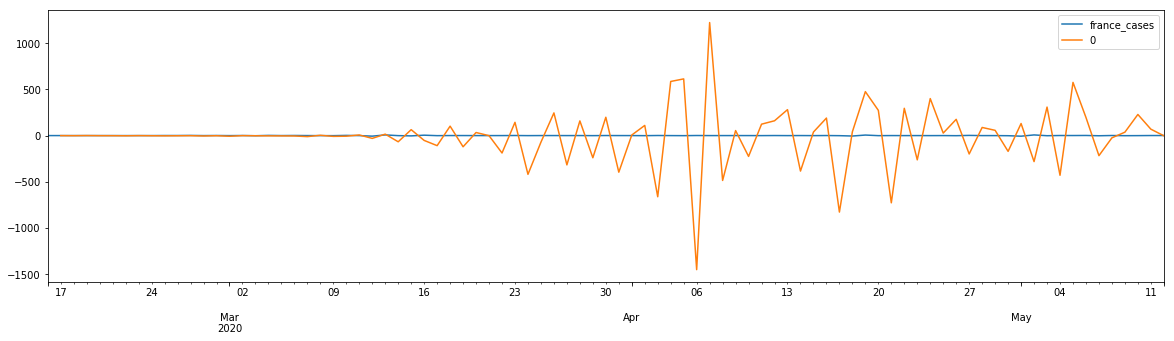

In [95]:
fitted_values  = results_ARIMA.predict(1,len(ts_fra_log)-1,typ='linear')
fitted_values_frame = fitted_values.to_frame()

x = ts_fra_log.merge(fitted_values_frame, how='outer', left_index=True, right_index=True)

fig= x.plot(y = ["france_cases", 0], figsize=(20,5))
display(fig.figure)

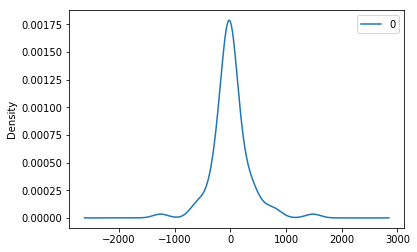

In [96]:
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

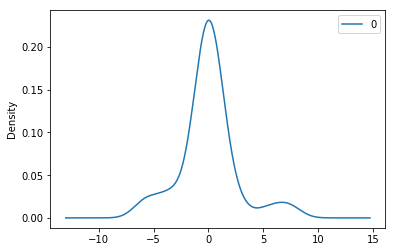

In [97]:
# plot residual errors
residuals = DataFrame(results_jap_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

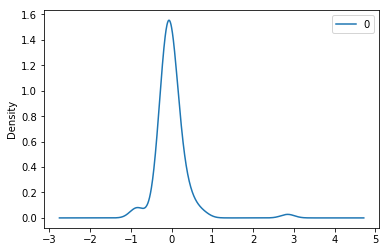

In [98]:
# plot residual errors
residuals = DataFrame(results_ita_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

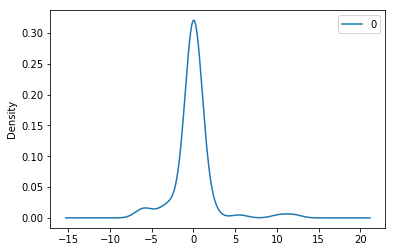

In [99]:
# plot residual errors
residuals = DataFrame(results_uk_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

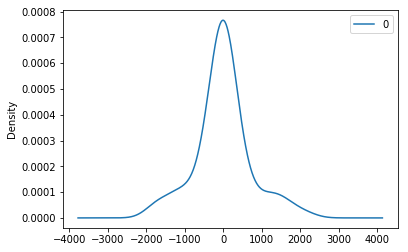

In [100]:
# plot residual errors
residuals = DataFrame(results_ger_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

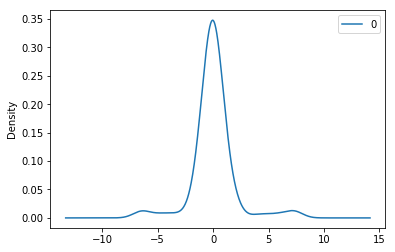

In [101]:
# plot residual errors
residuals = DataFrame(results_fra_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

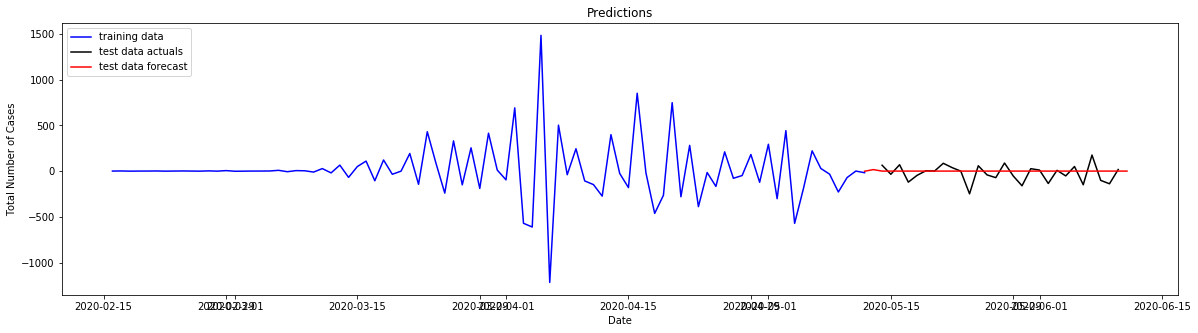

In [102]:
model_test = ARIMA(can_diff.astype(float), order=(0, 1, 1)) 
results_test_ARIMA = model_test.fit(maxiter=500) 

fitted_values_test  = results_test_ARIMA.predict(86,116,typ='linear') 
fitted_values_test_frame = fitted_values_test.to_frame()

fig, ax = plt.subplots(figsize=(20,5))
ax.set(title='Predictions', xlabel='Date', ylabel='Total Number of Cases')
ax.plot(can_diff, 'blue', label='training data') 
ax.plot(can_test_diff, 'black', label='test data actuals')
ax.plot(fitted_values_test_frame, 'r', label='test data forecast')  # np.exp(predictions_series)
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
display(fig.figure)

In [103]:
#smape
from sklearn import metrics

pred = fitted_values_test_frame.iloc[3:]

print(np.sqrt(metrics.mean_squared_error(can_test_diff, pred)))

94.83787634152249

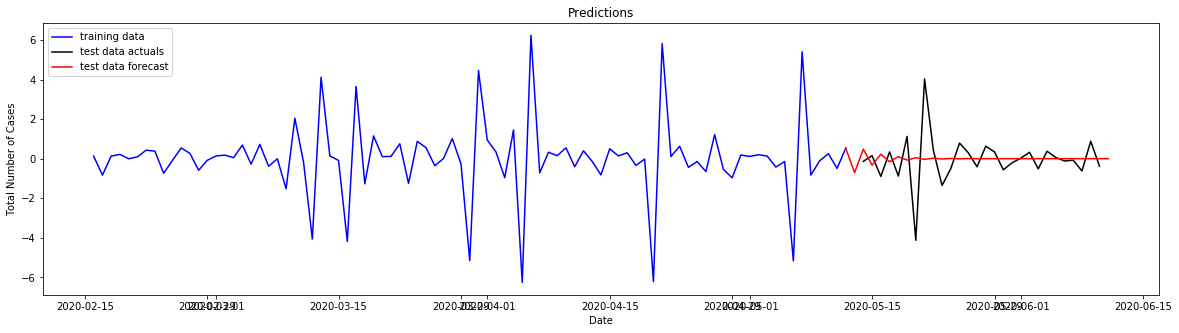

In [104]:
model_test = ARIMA(ts_jap_log.astype(float), order=(1, 1, 0)) 
results_test_ARIMA = model_test.fit(maxiter=500) 

fitted_values_test  = results_test_ARIMA.predict(86,116,typ='linear')  
fitted_values_test_frame = fitted_values_test.to_frame()

fig, ax = plt.subplots(figsize=(20,5))
ax.set(title='Predictions', xlabel='Date', ylabel='Total Number of Cases')
ax.plot(ts_jap_log, 'blue', label='training data') 
ax.plot(test_jap_log, 'black', label='test data actuals')
ax.plot(fitted_values_test_frame, 'r', label='test data forecast')  # np.exp(predictions_series)
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
display(fig.figure)

In [105]:
pred = fitted_values_test_frame.iloc[3:]

print(np.sqrt(metrics.mean_squared_error(test_jap_log, pred)))

1.214800546236386

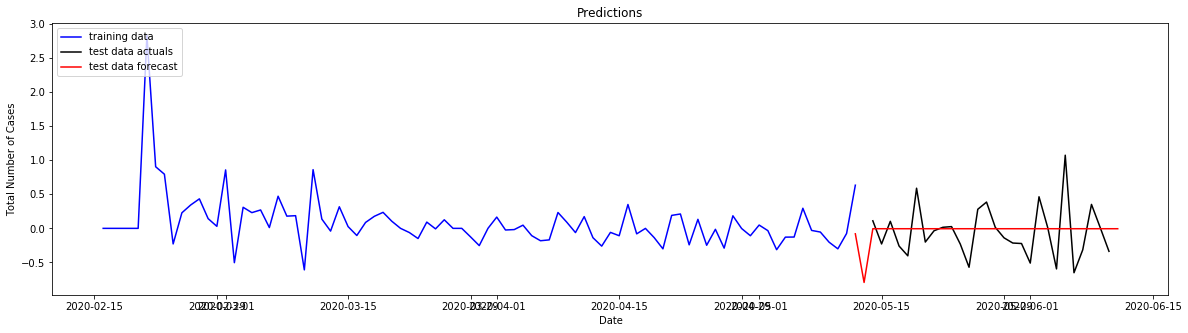

In [106]:
model_test = ARIMA(ts_ita_log.astype(float), order=(0, 1, 1))  
results_test_ARIMA = model_test.fit(maxiter=500) 

fitted_values_test  = results_test_ARIMA.predict(86,116,typ='linear') 
fitted_values_test_frame = fitted_values_test.to_frame()

fig, ax = plt.subplots(figsize=(20,5))
ax.set(title='Predictions', xlabel='Date', ylabel='Total Number of Cases')
ax.plot(ts_ita_log, 'blue', label='training data') 
ax.plot(test_ita_log, 'black', label='test data actuals')
ax.plot(fitted_values_test_frame, 'r', label='test data forecast')  # np.exp(predictions_series)
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
display(fig.figure)

In [107]:
pred = fitted_values_test_frame.iloc[3:]

print(np.sqrt(metrics.mean_squared_error(test_ita_log, pred)))

0.38481377753428675

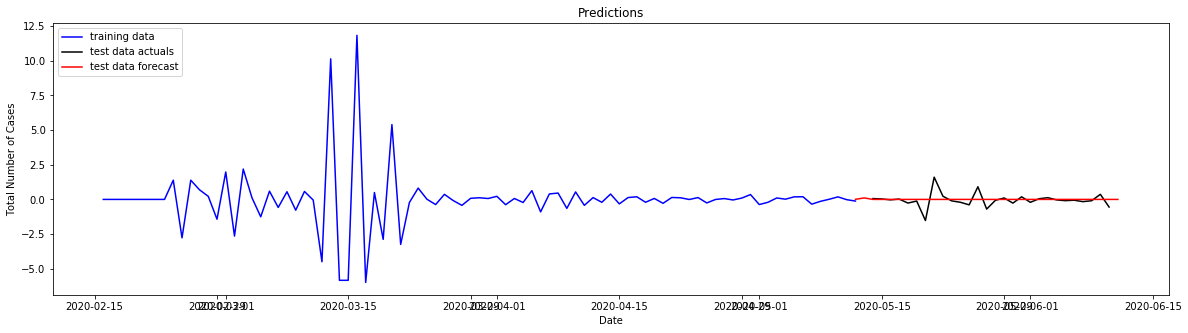

In [108]:
model_test = ARIMA(ts_uk_log.astype(float), order=(0, 1, 1))  
results_test_ARIMA = model_test.fit(maxiter=500) 

fitted_values_test  = results_test_ARIMA.predict(86,116,typ='linear') 
fitted_values_test_frame = fitted_values_test.to_frame()

fig, ax = plt.subplots(figsize=(20,5))
ax.set(title='Predictions', xlabel='Date', ylabel='Total Number of Cases')
ax.plot(ts_uk_log, 'blue', label='training data') 
ax.plot(test_uk_log, 'black', label='test data actuals')
ax.plot(fitted_values_test_frame, 'r', label='test data forecast')  # np.exp(predictions_series)
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
display(fig.figure)

In [109]:
pred = fitted_values_test_frame.iloc[3:]

print(np.sqrt(metrics.mean_squared_error(test_uk_log, pred)))

0.5085281609946365

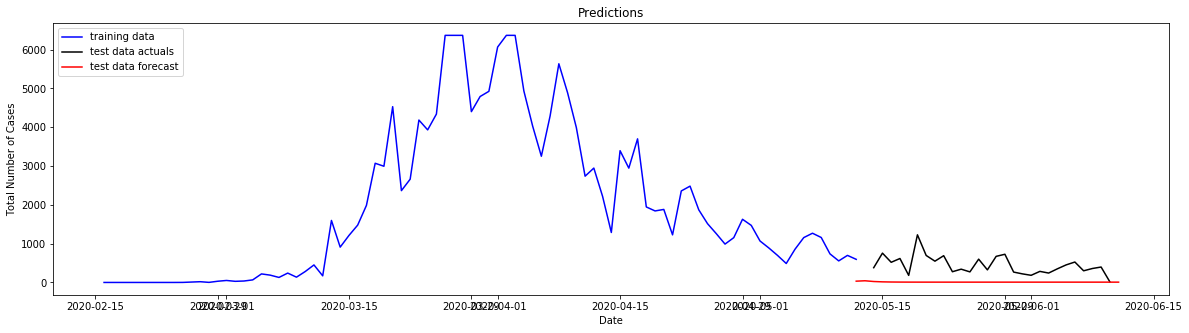

In [110]:
model_test = ARIMA(germany_final.astype(float), order=(1, 1, 1))  
results_test_ARIMA = model_test.fit(maxiter=500) 

fitted_values_test  = results_test_ARIMA.predict(86,116,typ='linear') 
fitted_values_test_frame = fitted_values_test.to_frame()

fig, ax = plt.subplots(figsize=(20,5))
ax.set(title='Predictions', xlabel='Date', ylabel='Total Number of Cases')
ax.plot(germany_final, 'blue', label='training data') 
ax.plot(germany_test, 'black', label='test data actuals')
ax.plot(fitted_values_test_frame, 'r', label='test data forecast')  # np.exp(predictions_series)
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
display(fig.figure)

In [111]:
pred = fitted_values_test_frame.iloc[3:]

print(np.sqrt(metrics.mean_squared_error(germany_test, pred)))

497.90669059968747

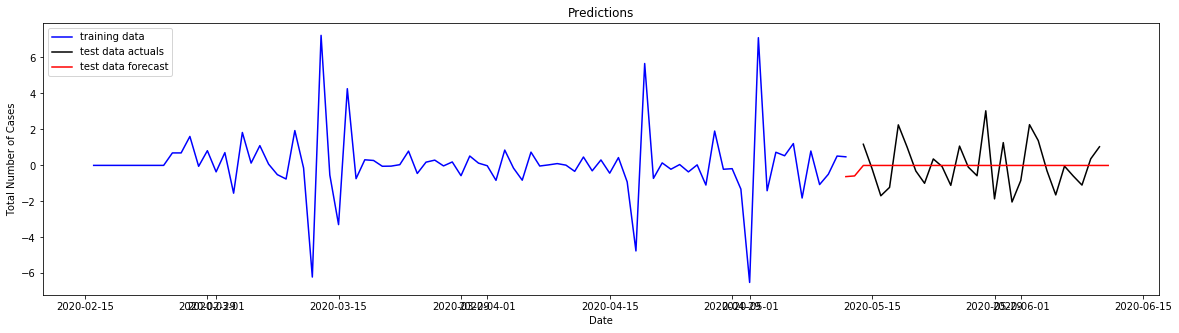

In [112]:
model_test = ARIMA(ts_fra_log.astype(float), order=(0, 1, 1))  
results_test_ARIMA = model_test.fit(maxiter=500) 

fitted_values_test  = results_test_ARIMA.predict(86, 116, typ='linear') #(1, len(test_fra_log-1))
fitted_values_test_frame = fitted_values_test.to_frame()

fig, ax = plt.subplots(figsize=(20,5))
ax.set(title='Predictions', xlabel='Date', ylabel='Total Number of Cases')
ax.plot(ts_fra_log, 'blue', label='training data') 
ax.plot(test_fra_log, 'black', label='test data actuals')
ax.plot(fitted_values_test_frame, 'r', label='test data forecast')  # np.exp(predictions_series)
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
display(fig.figure)

In [113]:
pred = fitted_values_test_frame.iloc[3:]

print(np.sqrt(metrics.mean_squared_error(test_fra_log, pred)))

1.3030514851176755

In [114]:
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of differencing.
#q: The size of the moving average window, also called the order of moving average.

In [115]:
history = [x for x in canada_final.astype(float)]

predictions = list()
for t in range(len(canada_test.astype(float))):
	model = ARIMA(history, order=(0, 1, 1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = can_test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(can_test_diff, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(can_test_diff)
pyplot.plot(predictions, color='red')
pyplot.show()

In [116]:
# Train dataset: 87 rows, Test Dataset: 30 rows
w = Window().partitionBy(lit('a')).orderBy(lit('a'))
# Number the rows 
train1 = can_diff.withColumn('row_num', row_number().over(w))
test1 = can_test_diff.withColumn('row_num', row_number().over(w))
for i in range(1,31): 
  if i ==1:
    traindf = train1.filter(col('row_num').between(1,87)).drop('row_num')  
    testsdf = test1.filter(col('row_num')==i+1).drop('row_num') # skip day 88 and predict for day 89
    
  elif i >=2:
    # shift training dataset
    train_1 = train1.filter(col('row_num').between(i,87)).drop('row_num') 
    
    # filter for the test days that have already been predicted and join with shifted training set
    test_1 = test1.filter(col('row_num').between(1,i-1)).drop('row_num') 
    traindf = train_1.union(test_1)                  
    
    testdf = test1.filter(col('row_num')==i).drop('row_num')  
                                
  model = ARIMA(can_diff.astype(float), order=(1, 1, 3)) 
  results_ARIMA = model.fit(maxiter=500)  
  fitted_values  = results_ARIMA.predict(1,len(can_diff)-1,typ='linear')
  fitted_values_frame = fitted_values.to_frame()
  predictions.select('canada_cases', 'prediction').show()
  
  x = can_diff.merge(fitted_values_frame, how='outer', left_index=True, right_index=True)

  fig= x.plot(y = ["canada_cases", 0], figsize=(20,5))
  display(fig.figure)
